# Pothole Risk Assessment System - Testing

This notebook tests the complete pipeline:
1. **Stage 1**: Segmentation using SAM (Segment Anything Model)
2. **Stage 2**: Depth Estimation using Depth Anything V2
3. **Stage 3**: Risk Assessment + Qdrant Storage

## 1. Setup and Imports

In [39]:
import sys
import os

# Add src to path
sys.path.insert(0, os.path.abspath('.'))

import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import torch

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

PyTorch version: 2.7.1+cu126
CUDA available: True
GPU: NVIDIA L40S


## 2. Load Sample Images from Dataset

In [40]:
# Path to new pothole segmentation dataset
dataset_path = "data/PotholesSegAnnotations-1/train"

# Get list of images (only .jpg files, not .json)
image_files = sorted([f for f in os.listdir(dataset_path) if f.endswith('.jpg')])[:10]
print(f"Found {len([f for f in os.listdir(dataset_path) if f.endswith('.jpg')])} images in dataset")
print(f"\nFirst 10 images:")
for img in image_files:
    print(f"  - {img}")

Found 866 images in dataset

First 10 images:
  - Pothole-001_jpg.rf.02d4ae6d97372b9a01c23e038dfc0a45.jpg
  - Pothole-002_jpg.rf.916bbe70de9c3e55619ed664ba9479c4.jpg
  - Pothole-003_jpg.rf.23fcd6d1c31aa7b3b4758042f43b1f72.jpg
  - Pothole-005_jpg.rf.5005cdc1d7d677862ffb66cf15f842ad.jpg
  - Pothole-007_jpg.rf.26db21752a921cd00a91fc381d47adb8.jpg
  - Pothole-008_jpg.rf.5ad08ee34b31ebd3a359db5aa6bfb587.jpg
  - Pothole-009_jpg.rf.e5424a202267fa135de65c5ea9773d16.jpg
  - Pothole-010_jpg.rf.bd91384bd85ac106e0022f047505e3d3.jpg
  - Pothole-012_jpg.rf.1b1a75a417d79fd330b459386ae5e459.jpg
  - Pothole-014_jpg.rf.ae08fe5a6771b7e8a7666df105ec820a.jpg


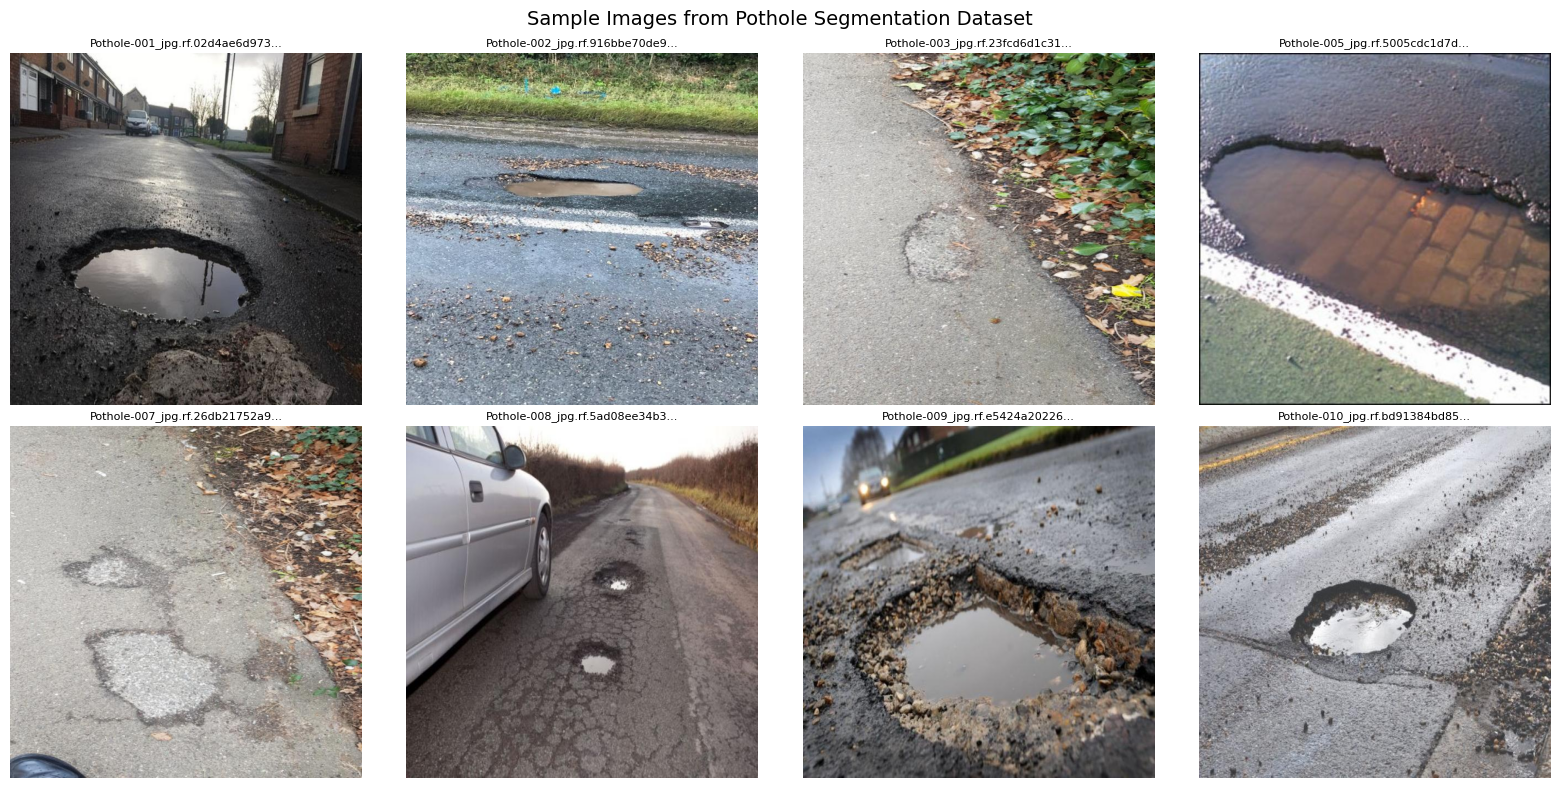

In [41]:
# Display sample images from new pothole dataset
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for idx, img_name in enumerate(image_files[:8]):
    img_path = os.path.join(dataset_path, img_name)
    img = Image.open(img_path)
    axes[idx].imshow(img)
    axes[idx].set_title(img_name[:30] + '...' if len(img_name) > 30 else img_name, fontsize=8)
    axes[idx].axis('off')

plt.suptitle('Sample Images from Pothole Segmentation Dataset', fontsize=14)
plt.tight_layout()
plt.show()

## 3. Stage 1: Load SAM Segmentation Model

In [42]:
from src.segmentation import PotholeSegmenter

# Initialize SAM segmenter
segmenter = PotholeSegmenter(
    checkpoint_path="models/sam_vit_h_4b8939.pth",
    model_type="vit_h",
    device="cuda"
)

Loading SAM model (vit_h) on cuda...
✓ SAM model loaded successfully


In [43]:
# Test segmentation on a sample image
test_image_path = os.path.join(dataset_path, image_files[0])
print(f"Testing on: {test_image_path}")

# Load image
image_bgr = cv2.imread(test_image_path)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

print(f"Image shape: {image_rgb.shape}")

Testing on: data/PotholesSegAnnotations-1/train/Pothole-001_jpg.rf.02d4ae6d97372b9a01c23e038dfc0a45.jpg
Image shape: (640, 640, 3)


In [44]:
# Run segmentation
print("Running SAM segmentation...")
all_masks = segmenter.segment_image(image_rgb)
print(f"Found {len(all_masks)} segments")

# Filter for potential potholes
pothole_masks = segmenter.filter_pothole_masks(all_masks, image_rgb)
print(f"Identified {len(pothole_masks)} potential potholes")

Running SAM segmentation...
Found 45 segments
Identified 3 potential potholes


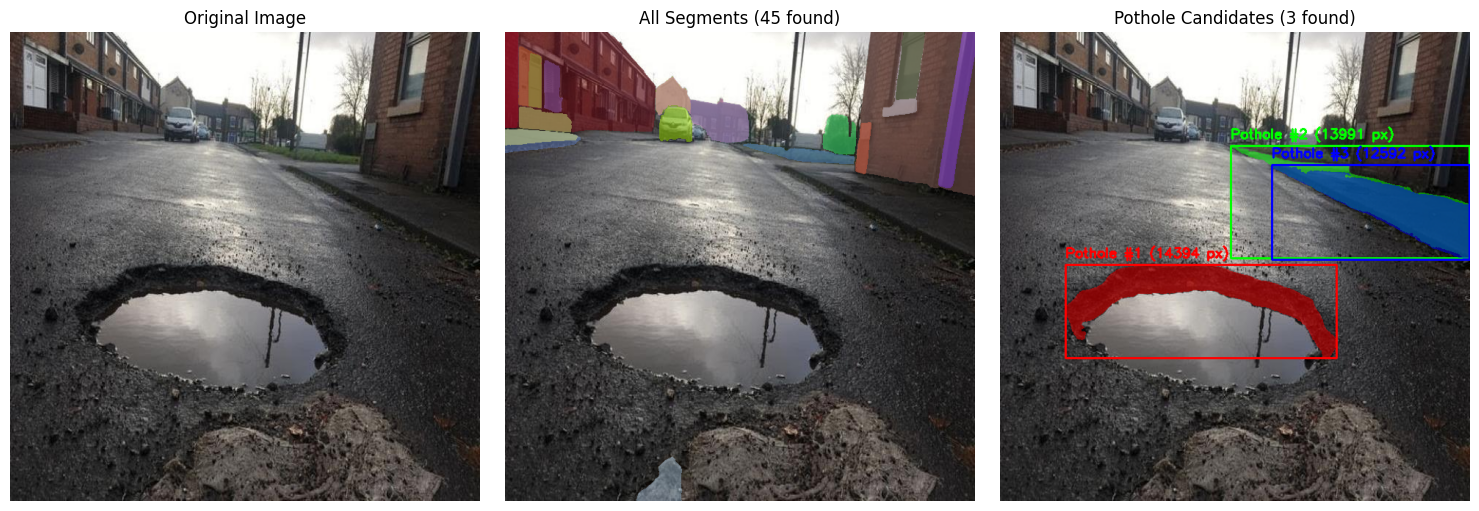

In [45]:
# Visualize segmentation results
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Original image
axes[0].imshow(image_rgb)
axes[0].set_title('Original Image')
axes[0].axis('off')

# All segments
all_mask_overlay = image_rgb.copy()
for mask in all_masks[:20]:  # Show first 20 masks
    color = np.random.randint(0, 255, 3)
    all_mask_overlay[mask['segmentation']] = color * 0.5 + all_mask_overlay[mask['segmentation']] * 0.5
axes[1].imshow(all_mask_overlay.astype(np.uint8))
axes[1].set_title(f'All Segments ({len(all_masks)} found)')
axes[1].axis('off')

# Pothole masks
pothole_vis = segmenter.visualize_masks(image_rgb, pothole_masks, alpha=0.5)
axes[2].imshow(pothole_vis)
axes[2].set_title(f'Pothole Candidates ({len(pothole_masks)} found)')
axes[2].axis('off')

plt.tight_layout()
plt.show()

## 4. Stage 2: Load Depth Estimation Model

In [46]:
from src.depth_estimation import DepthEstimator

# Initialize Depth Estimator
depth_estimator = DepthEstimator(
    model_name="depth-anything/Depth-Anything-V2-Large-hf",
    device="cuda"
)

Loading Depth Anything V2 on cuda...
✓ Depth Anything V2 loaded successfully


In [47]:
# Estimate depth
print("Estimating depth...")
pil_image = Image.fromarray(image_rgb)
depth_map_relative = depth_estimator.estimate_depth(pil_image)

print(f"Depth map shape: {depth_map_relative.shape}")
print(f"Depth range: {depth_map_relative.min():.3f} to {depth_map_relative.max():.3f}")

Estimating depth...
Depth map shape: (640, 640)
Depth range: -6.914 to 771.034


In [48]:
# Calibrate depth to meters
depth_map_calibrated = depth_estimator.calibrate_depth(
    depth_map_relative,
    calibration_method='camera_height',
    camera_height=1.5  # Assume camera at 1.5m height
)

print(f"Calibrated depth range: {depth_map_calibrated.min():.3f}m to {depth_map_calibrated.max():.3f}m")

Calibrated depth range: -0.015m to 1.712m


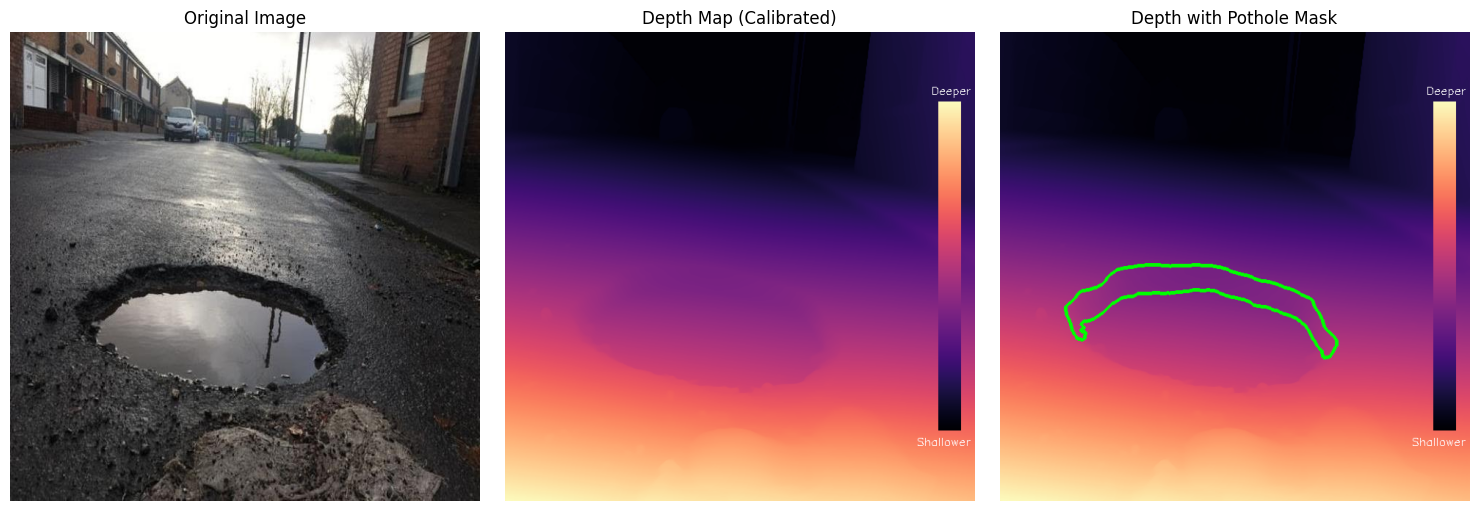

In [49]:
# Visualize depth
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Original
axes[0].imshow(image_rgb)
axes[0].set_title('Original Image')
axes[0].axis('off')

# Depth map
depth_vis = depth_estimator.visualize_depth(depth_map_calibrated)
axes[1].imshow(cv2.cvtColor(depth_vis, cv2.COLOR_BGR2RGB))
axes[1].set_title('Depth Map (Calibrated)')
axes[1].axis('off')

# Depth with pothole overlay
if pothole_masks:
    mask = pothole_masks[0]['segmentation']
    # Resize mask if needed
    if mask.shape != depth_map_calibrated.shape:
        mask = cv2.resize(mask.astype(np.uint8), 
                         (depth_map_calibrated.shape[1], depth_map_calibrated.shape[0]),
                         interpolation=cv2.INTER_NEAREST).astype(bool)
    depth_vis_mask = depth_estimator.visualize_depth(depth_map_calibrated, mask=mask)
    axes[2].imshow(cv2.cvtColor(depth_vis_mask, cv2.COLOR_BGR2RGB))
    axes[2].set_title('Depth with Pothole Mask')
else:
    axes[2].imshow(cv2.cvtColor(depth_vis, cv2.COLOR_BGR2RGB))
    axes[2].set_title('No potholes detected')
axes[2].axis('off')

plt.tight_layout()
plt.show()

## 5. Stage 3: Risk Assessment

In [50]:
from src.risk_assessment import RiskAssessor, QdrantRiskStorage

# Close existing storage connection if it exists
if 'storage' in dir() and storage is not None:
    try:
        storage.client.close()
        print("Closed existing Qdrant connection")
    except:
        pass

# Initialize Risk Assessor
risk_assessor = RiskAssessor()

# Initialize Qdrant Storage
storage = QdrantRiskStorage(
    qdrant_path="./data/qdrant_db",
    collection_name="pothole_risk_assessment"
)

Closed existing Qdrant connection
✓ Using existing Qdrant collection: pothole_risk_assessment


In [51]:
# Analyze pothole depth if we found any
if pothole_masks:
    mask = pothole_masks[0]['segmentation']
    
    # Resize mask if needed
    if mask.shape != depth_map_calibrated.shape:
        mask = cv2.resize(mask.astype(np.uint8), 
                         (depth_map_calibrated.shape[1], depth_map_calibrated.shape[0]),
                         interpolation=cv2.INTER_NEAREST).astype(bool)
    
    # Get depth analysis
    depth_analysis = depth_estimator.analyze_pothole_depth(depth_map_calibrated, mask, calibrated=True)
    print("Depth Analysis:")
    for key, value in depth_analysis.items():
        if key != 'depth_profile':
            print(f"  {key}: {value}")
    
    # Get volume estimate
    volume_analysis = depth_estimator.compute_volume_estimate(depth_map_calibrated, mask, pixel_to_meter=0.01)
    print("\nVolume Analysis:")
    for key, value in volume_analysis.items():
        print(f"  {key}: {value}")
else:
    print("No pothole masks found - using sample values for demo")
    depth_analysis = {'depth_max': 0.08, 'depth_mean': 0.05, 'depth_std': 0.02}
    volume_analysis = {'volume_m3': 0.05, 'area_m2': 0.5}

Depth Analysis:
  valid: True
  depth_max: 0.12949615716934204
  depth_min: -0.21603763103485107
  depth_mean: 0.036350857466459274
  depth_median: 0.06864818930625916
  depth_std: 0.07760990411043167
  road_surface_depth: 0.6997602581977844
  unit: m
  calibrated: True

Volume Analysis:
  volume_m3: 0.11189685761928558
  volume_liters: 111.89685821533203
  area_m2: 1.4394
  mean_depth_m: 0.07773854583501816
  max_depth_m: 0.21603763103485107
  pixel_count: 14394


In [52]:
# Calculate risk assessment
risk_result = risk_assessor.calculate_total_risk(
    depth_m=depth_analysis.get('depth_max', 0.08),
    area_m2=volume_analysis.get('area_m2', 0.5),
    volume_m3=volume_analysis.get('volume_m3', 0.05),
    depth_std=depth_analysis.get('depth_std', 0.02),
    circularity=0.5
)

print("\n" + "="*60)
print("RISK ASSESSMENT RESULTS")
print("="*60)
print(f"\nTotal Score: {risk_result['total_score']}/100")
print(f"Risk Level: {risk_result['risk_level']}")
print(f"Priority: {risk_result['priority']} of 4")
print(f"\nRecommended Action: {risk_result['recommended_action']}")
print(f"Response Time: {risk_result['response_time']}")

print("\nFactor Breakdown:")
for factor, data in risk_result['factors'].items():
    print(f"  {factor}: {data['score']}/{data['max_score']} - {data['level']}")


RISK ASSESSMENT RESULTS

Total Score: 70/100
Risk Level: HIGH
Priority: 2 of 4

Recommended Action: URGENT REPAIR - Deploy crew within 48 hours
Response Time: Within 48 hours

Factor Breakdown:
  depth: 30/40 - HIGH
  area: 20/30 - LARGE
  volume: 10/20 - MODERATE
  irregularity: 10/10 - SHARP_EDGES


In [53]:
# Generate full report
measurements = {
    'depth_max_m': depth_analysis.get('depth_max', 0.08),
    'depth_mean_m': depth_analysis.get('depth_mean', 0.05),
    'width_m': 0.6,
    'length_m': 0.8,
    'area_m2': volume_analysis.get('area_m2', 0.5),
    'volume_m3': volume_analysis.get('volume_m3', 0.05)
}

report = risk_assessor.generate_report(
    pothole_id="test-001",
    measurements=measurements,
    risk_assessment=risk_result,
    location={'lat': 28.6139, 'lon': 77.2090, 'address': 'New Delhi, India'},
    image_path=test_image_path
)

print(report)


╔══════════════════════════════════════════════════════════════════════════════╗
║                        POTHOLE RISK ASSESSMENT REPORT                        ║
╠══════════════════════════════════════════════════════════════════════════════╣
║ Report ID: test-001                                                 ║
║ Generated: 2026-01-21T00:43:11                                      ║
╚══════════════════════════════════════════════════════════════════════════════╝

┌─ LOCATION ───────────────────────────────────────────────────────────────────┐
│ GPS: 28.6139, 77.209
│ Address: New Delhi, India
└──────────────────────────────────────────────────────────────────────────────┘

┌─ PHYSICAL MEASUREMENTS ──────────────────────────────────────────────────────┐
│                                                                              │
│   Depth (Maximum):      12.9 cm                                    │
│   Depth (Average):       3.6 cm                                    │
│   Width:  

## 6. Full Pipeline Test with Analyzer

In [55]:
from src.analyzer import PotholeRiskAnalyzer

# Close existing storage connection before creating analyzer (which creates its own)
if 'storage' in dir() and storage is not None:
    try:
        storage.client.close()
        print("Closed existing Qdrant connection")
    except:
        pass

# Initialize the complete analyzer
analyzer = PotholeRiskAnalyzer(
    sam_checkpoint="models/sam_vit_h_4b8939.pth",
    sam_model_type="vit_h",
    device="cuda"
)

# Set calibration
analyzer.set_calibration(
    camera_height=1.5,
    pixel_to_meter=0.01
)

Closed existing Qdrant connection
Initializing Pothole Risk Assessment System

[Stage 1] Loading Segmentation Model (SAM)...
Loading SAM model (vit_h) on cuda...
✓ SAM model loaded successfully

[Stage 2] Loading Depth Estimation Model...
Loading Depth Anything V2 on cuda...
✓ Depth Anything V2 loaded successfully

[Stage 3] Setting up Risk Assessment and Storage...
✓ Using existing Qdrant collection: pothole_risk_assessment

Loading Embedding Model for Qdrant...


preprocessor_config.json:   0%|          | 0.00/436 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/548 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

✓ Embedding model loaded: facebook/dinov2-base

✓ System Initialized Successfully!

Calibration updated: {'camera_height': 1.5, 'pixel_to_meter': 0.01, 'lane_width': 3.5}


In [56]:
# Run full analysis on a test image
test_image = os.path.join(dataset_path, image_files[0])
print(f"Analyzing: {test_image}")

results = analyzer.analyze(
    image_path=test_image,
    location={
        'lat': 28.6139,
        'lon': 77.2090,
        'address': 'New Delhi, India'
    },
    save_visualization=True,
    output_dir="./outputs"
)

Analyzing: data/PotholesSegAnnotations-1/train/Pothole-001_jpg.rf.02d4ae6d97372b9a01c23e038dfc0a45.jpg

ANALYZING: data/PotholesSegAnnotations-1/train/Pothole-001_jpg.rf.02d4ae6d97372b9a01c23e038dfc0a45.jpg

[STAGE 1] Segmenting potholes...
  Found 45 segments
  Identified 3 potential potholes

[STAGE 2] Estimating depth...
  Depth map computed: (640, 640)

[STAGE 3] Computing measurements and risk assessment...

  Processing Pothole #1...
    Depth: 12.9 cm
    Area: 1.44 m²
    Risk Score: 70/100 (HIGH)

  Processing Pothole #2...
    Depth: 31.5 cm
    Area: 1.40 m²
    Risk Score: 80/100 (CRITICAL)

  Processing Pothole #3...
    Depth: 28.2 cm
    Area: 1.26 m²
    Risk Score: 80/100 (CRITICAL)

[STORAGE] Saving to Qdrant...
  Stored with Report ID: a043a760-21f0-4df5-91e9-d502117d3b39

[VISUALIZATION] Generating outputs...
  Saved visualizations to: ./outputs

[REPORT] Generating assessment report...

╔══════════════════════════════════════════════════════════════════════════════

In [57]:
# Display results summary
if results['status'] == 'success':
    print("\n" + "="*60)
    print("ANALYSIS SUMMARY")
    print("="*60)
    print(f"Report ID: {results['report_id']}")
    print(f"Total Potholes: {results['total_potholes']}")
    print(f"\nHighest Risk Pothole:")
    print(f"  Risk Score: {results['highest_risk']['risk_assessment']['total_score']}/100")
    print(f"  Risk Level: {results['highest_risk']['risk_assessment']['risk_level']}")
    print(f"  Depth: {results['highest_risk']['measurements']['depth_max_m']*100:.1f} cm")
    print(f"  Area: {results['highest_risk']['measurements']['area_m2']:.2f} m²")
    
    print(f"\nVisualization files:")
    for viz_type, path in results.get('visualizations', {}).items():
        print(f"  {viz_type}: {path}")
else:
    print(f"Analysis status: {results['status']}")


ANALYSIS SUMMARY
Report ID: a043a760-21f0-4df5-91e9-d502117d3b39
Total Potholes: 3

Highest Risk Pothole:
  Risk Score: 80/100
  Risk Level: CRITICAL
  Depth: 31.5 cm
  Area: 1.40 m²

Visualization files:
  segmentation: ./outputs/a043a760_segmentation.jpg
  depth: ./outputs/a043a760_depth.jpg
  report: ./outputs/a043a760_report.txt


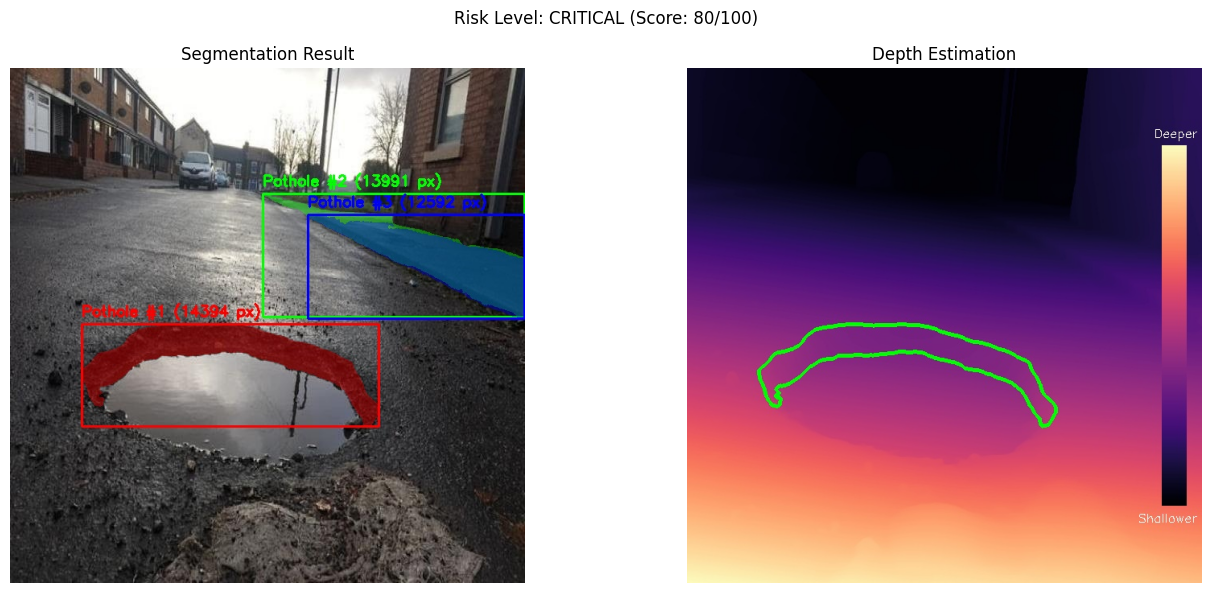

In [58]:
# Display visualizations if they were saved
if results.get('visualizations'):
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Segmentation
    if 'segmentation' in results['visualizations']:
        seg_img = cv2.imread(results['visualizations']['segmentation'])
        axes[0].imshow(cv2.cvtColor(seg_img, cv2.COLOR_BGR2RGB))
        axes[0].set_title('Segmentation Result')
        axes[0].axis('off')
    
    # Depth
    if 'depth' in results['visualizations']:
        depth_img = cv2.imread(results['visualizations']['depth'])
        axes[1].imshow(cv2.cvtColor(depth_img, cv2.COLOR_BGR2RGB))
        axes[1].set_title('Depth Estimation')
        axes[1].axis('off')
    
    plt.suptitle(f"Risk Level: {results['highest_risk']['risk_assessment']['risk_level']} (Score: {results['highest_risk']['risk_assessment']['total_score']}/100)")
    plt.tight_layout()
    plt.show()

## 7. Batch Analysis on Multiple Images

In [59]:
# Analyze multiple images
batch_results = []

for img_name in image_files[:5]:  # First 5 images
    img_path = os.path.join(dataset_path, img_name)
    print(f"\nAnalyzing: {img_name}")
    
    try:
        result = analyzer.analyze(
            image_path=img_path,
            save_visualization=False  # Skip saving for batch
        )
        batch_results.append({
            'image': img_name,
            'status': result['status'],
            'potholes': result.get('total_potholes', 0),
            'risk_score': result.get('highest_risk', {}).get('risk_assessment', {}).get('total_score', 0),
            'risk_level': result.get('highest_risk', {}).get('risk_assessment', {}).get('risk_level', 'N/A')
        })
    except Exception as e:
        print(f"  Error: {e}")
        batch_results.append({
            'image': img_name,
            'status': 'error',
            'potholes': 0,
            'risk_score': 0,
            'risk_level': 'ERROR'
        })


Analyzing: Pothole-001_jpg.rf.02d4ae6d97372b9a01c23e038dfc0a45.jpg

ANALYZING: data/PotholesSegAnnotations-1/train/Pothole-001_jpg.rf.02d4ae6d97372b9a01c23e038dfc0a45.jpg

[STAGE 1] Segmenting potholes...
  Found 45 segments
  Identified 3 potential potholes

[STAGE 2] Estimating depth...
  Depth map computed: (640, 640)

[STAGE 3] Computing measurements and risk assessment...

  Processing Pothole #1...
    Depth: 12.9 cm
    Area: 1.44 m²
    Risk Score: 70/100 (HIGH)

  Processing Pothole #2...
    Depth: 31.5 cm
    Area: 1.40 m²
    Risk Score: 80/100 (CRITICAL)

  Processing Pothole #3...
    Depth: 28.2 cm
    Area: 1.26 m²
    Risk Score: 80/100 (CRITICAL)

[STORAGE] Saving to Qdrant...
  Stored with Report ID: 3231374d-2569-45aa-8751-e4f0e5dd3e10

[REPORT] Generating assessment report...

╔══════════════════════════════════════════════════════════════════════════════╗
║                        POTHOLE RISK ASSESSMENT REPORT                        ║
╠═══════════════════════════

In [60]:
# Display batch results
print("\n" + "="*80)
print("BATCH ANALYSIS RESULTS")
print("="*80)
print(f"{'Image':<25} {'Status':<15} {'Potholes':<10} {'Risk Score':<12} {'Level'}")
print("-"*80)

for r in batch_results:
    print(f"{r['image']:<25} {r['status']:<15} {r['potholes']:<10} {r['risk_score']:<12} {r['risk_level']}")


BATCH ANALYSIS RESULTS
Image                     Status          Potholes   Risk Score   Level
--------------------------------------------------------------------------------
Pothole-001_jpg.rf.02d4ae6d97372b9a01c23e038dfc0a45.jpg success         3          80           CRITICAL
Pothole-002_jpg.rf.916bbe70de9c3e55619ed664ba9479c4.jpg success         3          55           MEDIUM
Pothole-003_jpg.rf.23fcd6d1c31aa7b3b4758042f43b1f72.jpg success         1          35           LOW
Pothole-005_jpg.rf.5005cdc1d7d677862ffb66cf15f842ad.jpg success         4          100          CRITICAL
Pothole-007_jpg.rf.26db21752a921cd00a91fc381d47adb8.jpg success         2          75           HIGH


## 8. Query Similar Cases from Qdrant

In [61]:
# Find similar cases
if results['status'] == 'success':
    similar_cases = analyzer.find_similar_cases(
        test_image,
        limit=5
    )


🔍 Found 5 similar cases:

1. Similarity: 1.0000
   Report ID: 3231374d...
   Date: 2026-01-21T00:45:46.158788
   Risk: CRITICAL (80/100)
   Location: {}

2. Similarity: 1.0000
   Report ID: a043a760...
   Date: 2026-01-21T00:45:40.583752
   Risk: CRITICAL (80/100)
   Location: {'lat': 28.6139, 'lon': 77.209, 'address': 'New Delhi, India'}

3. Similarity: 0.7739
   Report ID: 79c00016...
   Date: 2026-01-21T00:46:01.098246
   Risk: CRITICAL (100/100)
   Location: {}

4. Similarity: 0.7041
   Report ID: c083244e...
   Date: 2026-01-21T00:45:51.291477
   Risk: MEDIUM (55/100)
   Location: {}

5. Similarity: 0.5265
   Report ID: 66d708f2...
   Date: 2026-01-21T00:46:06.298080
   Risk: HIGH (75/100)
   Location: {}


In [62]:
# Get database statistics
stats = analyzer.get_statistics()
print("\nDatabase Statistics:")
print(f"  Total Reports: {stats['total_reports']}")
print(f"  Average Risk Score: {stats['average_score']:.1f}")
print(f"  Risk Distribution: {stats['risk_distribution']}")


Database Statistics:
  Total Reports: 6
  Average Risk Score: 70.8
  Risk Distribution: {'CRITICAL': 3, 'HIGH': 1, 'MEDIUM': 1, 'LOW': 1}


## 9. Cleanup

In [63]:
# Optional: Clear GPU memory
import gc
torch.cuda.empty_cache()
gc.collect()
print("GPU memory cleared")

GPU memory cleared
